# **BERTopic sur des transcription du podcast**

BERTopic est un puissant framework pour analyser les données textuelles.
Nous allons l'utiliser dans ce projet pour analyser des transcriptions du podcast [GDIY](https://www.gdiy.fr/).
Les données ont été netoyées pour faciliter la compréhension. Vous pouvez trouver les données sur ce repo [Github](https://github.com/MNIKIEMA/gdiy-search/tree/main/gdiy_json_data).

**Disclaimer**: Je ne suis pas sponsorisé par le podcast Génération Do It Yourself.

In [1]:
%%capture

#!pip install safetensors
#%pip install datasets
#%pip install datashader
#%pip install adjustText

# **La base de donnée**
- Les transcriptions ont été nettoyées en supprimant les mots non important
- Les données sont de format `json` et subdivisées en petit bloc pour calculer les embeddings
- On a le format suivant:
```json
{
    "text": ["text_1", "text_2", "etc"],
    "date": ["date_1", "date_2", "etc"]
}
```

In [1]:
from sentence_transformers import SentenceTransformer
import json
from nltk.corpus import stopwords
import numpy as np

In [2]:
with open('./dataset/clean_docs.json', 'r') as f:
    data = json.load(f)

docs = data['text']
date = data['date']

print(len(docs))

49892


# **Premier pas avec Bertopic**

- On va illustrer l'entrainement sur une base de donnée en utiliser quelques lignes de codes.
- Plus tard, nous allons explorer la modularité de `Bertopic`

## Embeddings

- Nous pré-calculerons et sauvegarderons les embeddings pour le modèle BERTopic
- Cela nous permet de gagner du temps en évitant cette étape lors des itérations futures sur le modèle.

In [3]:
MPNET = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
MINI_LM = 'sentence-transformers/all-MiniLM-L6-v2'
S_CAMEMBERT = 'dangvantuan/sentence-camembert-base'

In [4]:
# Creation des embeddings
# model = SentenceTransformer(MPNET)
# embeddings = model.encode(docs, show_progress_bar=True)

Il est recommendé de sauvegarder les embeddings pour ne pas les calculer tout temps:

In [93]:
# with open('./mpnet-embeddings.npy', 'wb') as f:
    # np.save(f, embeddings)

- On peut les charger en mémoire comme suit:

In [26]:
embeddings = np.load("./minilm-embeddings.npy")

## Preparation du vocabulaire

L'auteur suggère de préparer le vocabulaire en amont pour économiser de la mémoire avant d'entraîner leur modèle.

Cette étape, bien que facultative avec assez de RAM, peut aider à réduire son utilisation. 

Il recommande aussi d'utiliser un `CountVectorizer` personnalisé plutôt que le `CountVectorizer` par défaut, s'il est disponible.

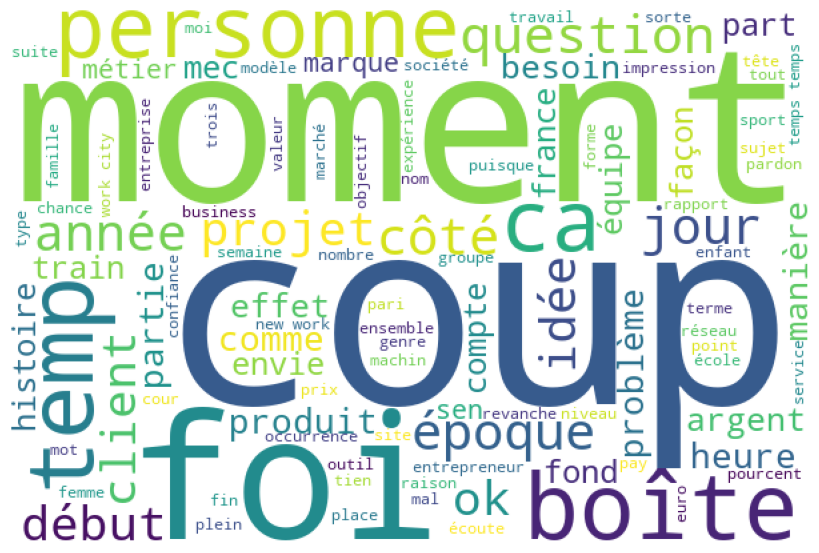

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = ' '.join(docs)

wordcloud = WordCloud(width = 600, height = 400, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [11]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Construction du vocabulaire
all_vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
  all_vocab.update(tokenizer(doc))

100%|██████████| 49892/49892 [00:00<00:00, 69789.36it/s]


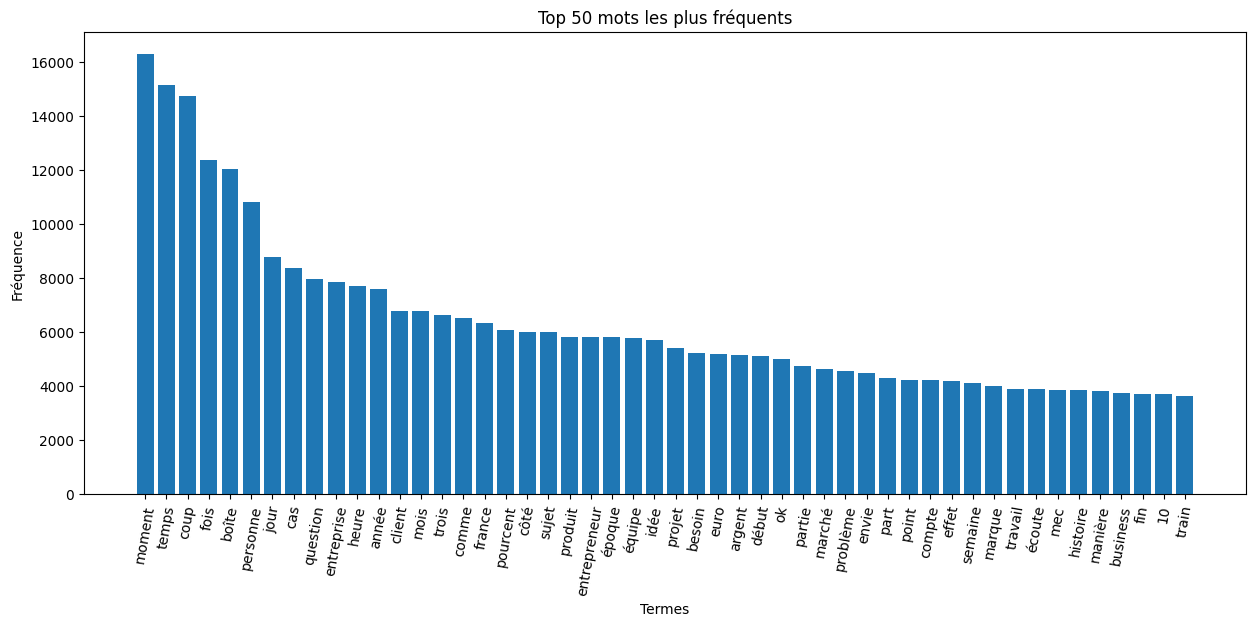

In [14]:
import matplotlib.pyplot as plt

top_n = 50
most_common_words = all_vocab.most_common(top_n)

# Separate the words and their frequencies
words, frequencies = zip(*most_common_words)

# Create a bar plot

plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xlabel('Termes')
plt.ylabel('Fréquence')
plt.title('Top ' + str(top_n) +' mots les plus fréquents')
plt.xticks(rotation=80)
plt.show()

In [15]:
stopword = stopwords.words('french')

- On peut ainsi voir le nombre de mots dans notre vocabulaire

In [16]:
# On garde les mots dont la fréquence est supérieur à 15
vocab = [word for word, frequency in all_vocab.items() if frequency >= 15]

In [17]:
len(vocab)

6731

## Entrainement de `BERTopic`

Nous pouvons entraîner notre modèle `BERTopic`.

Nous sélectionnons un modèle d'embeddings de phrases de la librairie SentenceTransformer et nous choisissons les modèles `HDBSCAN` et `UMAP`. 

Nvidia a développé des versions accélérées par GPU de `HDBSCAN` et `UMAP`, ce qui permet d'améliorer l'entraînement sur un ensemble de données aussi volumineux.

In [30]:
from umap import UMAP
import hdbscan
from bertopic import BERTopic

# Preparation des modèles

#
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
# UMAP
umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42,
                  metric="euclidean", verbose=True)
# HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_samples=20, gen_min_span_tree=True,
                                prediction_data=True, min_cluster_size=20)
# Vectorizer
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True
).fit(docs, embeddings=embeddings)

UMAP(n_components=5, n_neighbors=50, random_state=42, verbose=True)
Sun Nov 19 15:04:12 2023 Construct fuzzy simplicial set
Sun Nov 19 15:04:12 2023 Finding Nearest Neighbors
Sun Nov 19 15:04:12 2023 Building RP forest with 16 trees
Sun Nov 19 15:04:12 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Sun Nov 19 15:04:19 2023 Finished Nearest Neighbor Search
Sun Nov 19 15:04:20 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Nov 19 15:05:26 2023 Finished embedding


2023-11-19 15:05:26,303 - BERTopic - Reduced dimensionality
2023-11-19 15:05:29,541 - BERTopic - Clustered reduced embeddings
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\bertopic\vectorizers\_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


Nous pouvons examiner les sujets comme suit :

In [105]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,31423,-1_coup_boîte_temps_moment,"[coup, boîte, temps, moment, personne, mois, h...",[angel départ année marque temps marque temps ...
1,0,1097,0_mail_téléphone_internet_apple,"[mail, téléphone, internet, apple, contact, sm...",[device distance apple expérience info année a...
2,1,905,1_restaurant_chef_cuisine_café,"[restaurant, chef, cuisine, café, restauration...",[fois concept restaurant partage trois suite v...
3,2,810,2_musique_album_artiste_disque,"[musique, album, artiste, disque, dj, piano, c...",[réaction musique platine chambre ado musique ...
4,3,673,3_entrepreneur_entrepreneuriat_investisseur_pr...,"[entrepreneur, entrepreneuriat, investisseur, ...",[guillemet trois problème entrepreneur entrepr...
...,...,...,...,...,...
152,151,21,151_sensibilité_précaution_rappel_valeur,"[sensibilité, précaution, rappel, valeur, faib...",[mec réponse philosophie bien-être groupe phil...
153,152,21,152_muscle_cerveau_rein_genou,"[muscle, cerveau, rein, genou, entraînement, a...",[algorithme boîte heure tiktok algorithme vidé...
154,153,21,153_ultra_legal_domiciliation_juriste,"[ultra, legal, domiciliation, juriste, solutio...",[numéro 1 création gestion entreprise entrepre...
155,154,21,154_model_business_papernest_plan,"[model, business, papernest, plan, input, nide...",[banque épargne business model affiliation dép...


## Visualisation des thèmes
### Diagramme en barre

In [106]:
topic_model.visualize_barchart(top_n_topics = 8)

In [107]:
topic_model.visualize_topics()

### Visualiser la hiérarchie des thèmes

- Certaines thématiques sont en fait des sous-thèmes d'autres thématiques.
- Comprendre la hiérarchie permet de déterminer quelles thématiques devraient être fusionnées et lesquelles ne le devraient pas.

In [108]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 155/155 [00:01<00:00, 140.76it/s]


In [109]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [37]:
def fit_bertopic_model(docs=docs, embeddings=embeddings, vocab=vocab, stopword=stopword, 
                       embedding_model_name=MINI_LM, representation_model=None, y=None):
    """
    Fits a BERTopic model with custom configurations.

    :param docs: List of documents to fit the model.
    :param embeddings: Pre-computed embeddings for the documents.
    :param vocab: Vocabulary for the CountVectorizer.
    :param stopword: List of stopwords.
    :param embedding_model_name_or_instance: The name of the embedding model or an already initialized model instance.
    :return: Fitted BERTopic model.
    """
    # Load or use the provided sentence transformer model
    
    embedding_model = SentenceTransformer(embedding_model_name)

    # Initialize UMAP
    umap_model = UMAP(n_components=5, n_neighbors=50, random_state=42,
                      metric="euclidean", verbose=True)

    # Initialize HDBSCAN
    hdbscan_model = hdbscan.HDBSCAN(min_samples=20, gen_min_span_tree=True,
                                    prediction_data=True, min_cluster_size=20)

    # Initialize CountVectorizer
    vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words=list(stopword))

    # Fit BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True,
        representation_model=representation_model
    ).fit(docs, embeddings=embeddings)

    return topic_model


In [20]:
topic_model = fit_bertopic_model(docs=docs, embeddings=embeddings)

UMAP(n_components=5, n_neighbors=50, random_state=42, verbose=True)
Sun Nov 19 14:53:04 2023 Construct fuzzy simplicial set
Sun Nov 19 14:53:04 2023 Finding Nearest Neighbors
Sun Nov 19 14:53:04 2023 Building RP forest with 16 trees
Sun Nov 19 14:53:10 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Sun Nov 19 14:53:34 2023 Finished Nearest Neighbor Search
Sun Nov 19 14:53:38 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Nov 19 14:54:49 2023 Finished embedding


2023-11-19 14:54:49,948 - BERTopic - Reduced dimensionality
2023-11-19 14:54:53,785 - BERTopic - Clustered reduced embeddings
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\bertopic\vectorizers\_ctfidf.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


In [25]:
embeddings.shape

(49892, 384)

In [33]:
topic_model.transform(documents=["la situation de la boîte s'est améliorée et tu as levé de l'argent"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Epochs completed:   0%|            0/100 [00:00]

2023-11-19 15:07:58,951 - BERTopic - Reduced dimensionality
2023-11-19 15:07:58,951 - BERTopic - Predicted clusters


([-1], array([0.]))

In [35]:
from datetime import datetime
date_format = [datetime.strptime(date_time, "%d/%m/%Y") for date_time in date]

In [36]:
topics_over_time = topic_model.topics_over_time(docs, date_format,
                                                global_tuning=True,
                                                evolution_tuning=True,
                                                nr_bins=20)

topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

20it [00:04,  4.18it/s]


Enfin, on sauvegarder le modèle de la manière suivante :

In [93]:
topic_model.save(
    path='./BERTopic_Gdiy',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model=True,
)

# **Modularités**

- On peut tirer profit de la modularité pour entrainer chaque composant du modèle.
- Les modèles UMAP et HDBSCAN seront entrainés avant des les mettre dans `BERTopic`

## UMAP

- On peut jouer avec `n_components` qui donne la dimension du vecteur en sortie
- `n_neighbors` contrôle la façon dont l'algorithme équilibre la structure locale par rapport à la structure globale dans les données.
-  de faibles valeurs de `n_neighbors` se focalisent sur les détails locaux tandis que des valeurs élevées capturent les tendances globales des données, mais peuvent omettre certains détails.
- `metric` désigne la métrique utilisée : `cosine`, `euclidean`

In [112]:
from umap import UMAP

# On va appliquer une réduction de dimension avec une sortie de dimension 5
# et une distance cosinus
# On va également utiliser 15 voisins

umap_model = UMAP(n_components=5, n_neighbors=15, random_state=42, 
                  metric="cosine", verbose=True)
reduced_embeddings = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_components=5, random_state=42, verbose=True)
Sun Nov 19 12:22:23 2023 Construct fuzzy simplicial set
Sun Nov 19 12:22:23 2023 Finding Nearest Neighbors
Sun Nov 19 12:22:23 2023 Building RP forest with 16 trees
Sun Nov 19 12:22:23 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	Stopping threshold met -- exiting after 8 iterations
Sun Nov 19 12:22:26 2023 Finished Nearest Neighbor Search
Sun Nov 19 12:22:26 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Nov 19 12:23:05 2023 Finished embedding


De même, nous pouvons également préparer les embeddings réduits par `UMAP` pour la visualisation de documents en 2D:

In [113]:
from umap import UMAP

# On applique ici une réduction de dimension avec une sortie de dimension 2
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42,
                  metric="cosine", verbose=True)

reduced_embeddings_2d = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', random_state=42, verbose=True)
Sun Nov 19 12:23:06 2023 Construct fuzzy simplicial set
Sun Nov 19 12:23:06 2023 Finding Nearest Neighbors
Sun Nov 19 12:23:06 2023 Building RP forest with 16 trees
Sun Nov 19 12:23:06 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	Stopping threshold met -- exiting after 8 iterations
Sun Nov 19 12:23:08 2023 Finished Nearest Neighbor Search
Sun Nov 19 12:23:09 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun Nov 19 12:23:46 2023 Finished embedding


## HDBSCAN

Pour le clustering:
- `min_samples` désigne  le nombre minimum d'exemples requis dans un voisinage pour qu'un point soit considéré comme un noyau.
- `min_cluster_size` définit la taille minimale d'un cluster
- `gen_min_span_tree` générer l'arbre

In [114]:
from hdbscan import HDBSCAN

# Find clusters of semantically similar documents
hdbscan_model = HDBSCAN(min_samples=30, gen_min_span_tree=True,
                        prediction_data=False, min_cluster_size=30)
clusters = hdbscan_model.fit(reduced_embeddings).labels_

## Utilisation des vecteurs pré-calculer

- On définit une classe qui comporte une méthode `fit` et `transform` pour la réduction de dimension
- On passe les clusters calculés dans le model

In [115]:
from bertopic.cluster import BaseCluster
from transformers import pipeline
from bertopic.representation import KeyBERTInspired


class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings


# Prepare sub-models
embedding_model = SentenceTransformer('dangvantuan/sentence-camembert-base')
umap_model = Dimensionality(reduced_embeddings)

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        verbose=True
).fit(docs, embeddings=embeddings, y=clusters)

2023-11-19 12:23:53,443 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-11-19 12:23:53,444 - BERTopic - Reduced dimensionality
2023-11-19 12:23:53,456 - BERTopic - Clustered reduced embeddings
c:\Users\MahamadiNikiema\anaconda3\envs\podcast-env\lib\site-packages\bertopic\vectorizers\_ctfidf.py:69: RuntimeWarning:

divide by zero encountered in divide



In [116]:
topic_model.visualize_barchart()

## Visualize Documents

In [117]:
import itertools
import pandas as pd

# Couleurs pour la visalisation
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                           '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                           '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                           '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
                           '#ffffff', '#000000'])

color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Transformer les embeddings en dataframe
df = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1],
                   "Topic": [str(t) for t in topic_model.topics_]})

df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Calculer les centroids des clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

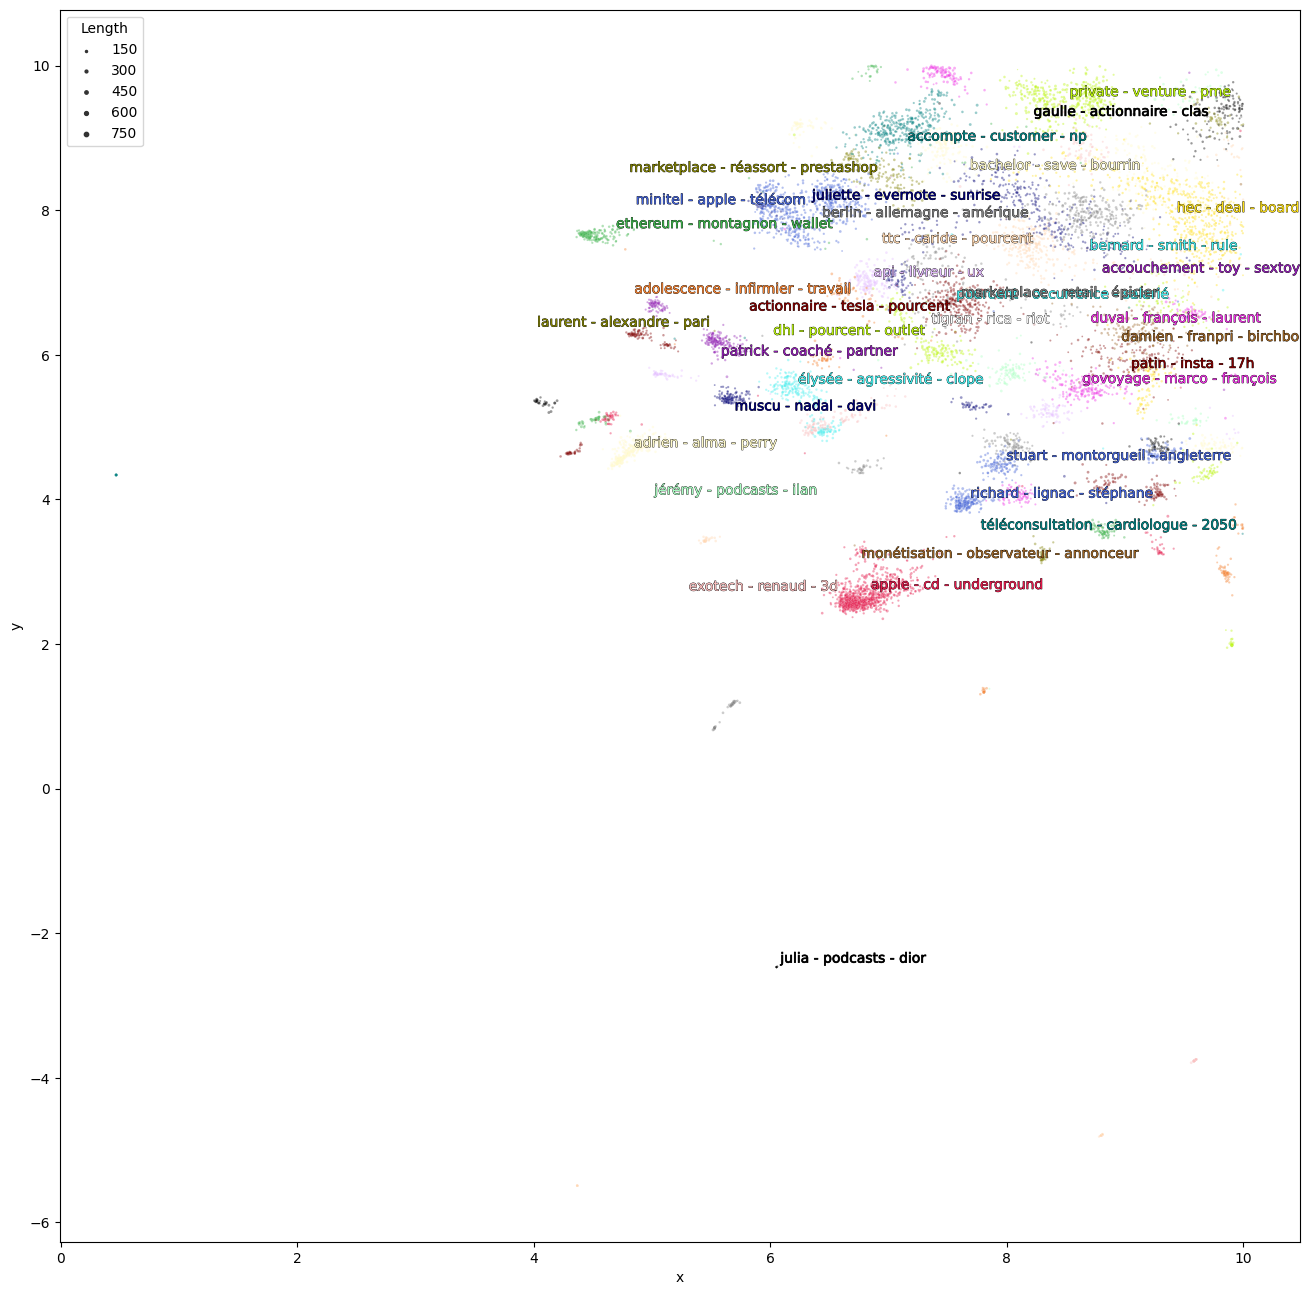

<Figure size 640x480 with 0 Axes>

In [118]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4,
                sizes=(0.4, 10), size="Length")

# Annotater les 50 premiers tthèmes
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center",
                          color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))


adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02),
            force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
plt.savefig("output.png", dpi=600)

## Amélioration des thèmes

- On peut les termes en utilisant la fonction `representation`

![Amélioration des thèmes](keybert.png)

### Avec des techniques d'extraction de mots clés

- On utiliser ici `KeyBERTInspired`

In [ ]:
keybert_representation_model = KeyBERTInspired()

fit_bertopic_model(docs=docs, representation_model=keybert_representation_model)


- On peut affiner les thèmes en utilisant GPT3

In [18]:
import openai
from bertopic.representation import OpenAI
import os

openai.api_key = os.environ["OPENAI_API_KEY"]
representation_model = OpenAI()
prompt = "J'ai les documents suivants : [DOCUMENTS] \nCes documents portent sur le sujet suivant :"
gpt_representation_model = OpenAI(prompt=prompt)

fit_bertopic_model(docs=docs, representation_model=keybert_representation_model)